# Imports

In [5]:
import os
import numpy as np
import random
import cv2

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# prediction on unseen data

In [2]:
model = load_model("finetuned_model.keras")

In [ ]:
# Define a dictionary mapping folder names to numeric labels
label_mapping = {
    "curling": 0,
    "lying": 1,
    "sitting": 2
}

# Function to load and preprocess unseen images
def load_and_preprocess_images(data_folder, img_size):
    images = []
    true_labels = []
    image_paths = []  # List to store paths of each image
    for label_name in os.listdir(data_folder):
        label_folder = os.path.join(data_folder, label_name)
        if label_name in label_mapping:  # Ensure the label is in the mapping
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img) / 255.0  # Normalize pixel values
                images.append(img_array)
                true_labels.append(label_mapping[label_name])  # Use the mapping dictionary
                image_paths.append(img_path)  # Store the image path
    return np.array(images), true_labels, image_paths  # Return image paths along with images and true labels

# Load and preprocess unseen images
data_folder = "03_occupancy_grid/combined_set"
img_size = (100, 100)
unseen_images, true_labels, image_paths = load_and_preprocess_images(data_folder, img_size)

# Define a dictionary mapping numeric labels to folder names (pose names)
pose_folders = {
    0: "curling",
    1: "lying",
    2: "sitting"
}

# Make predictions on unseen images
predictions = model.predict(unseen_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(pose_folders.values()))
cm_display.plot(cmap='Blues', xticks_rotation='vertical')
cm_display.ax_.set_title('Confusion Matrix')

plt.show()

# Prediction for random pose

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


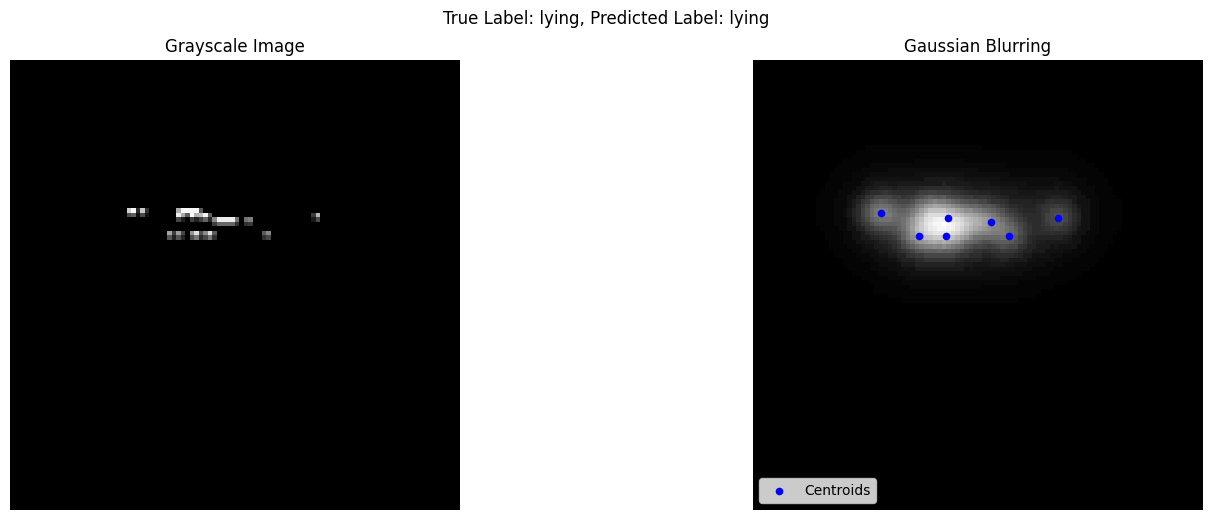

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import DBSCAN

# Randomly select an image and get info
random_index = random.randint(0, len(unseen_images) - 1)
random_image = unseen_images[random_index]
random_true_label = true_labels[random_index]
random_image_path = image_paths[random_index]

# Predict the label
random_prediction = model.predict(np.expand_dims(random_image, axis=0))
predicted_label = np.argmax(random_prediction)

# Prepare figure
plt.figure(figsize=(15, 10))
plt.suptitle(f"True Label: {pose_folders[random_true_label]}, Predicted Label: {pose_folders[predicted_label]}")

# Convert to grayscale
random_image_normalized = (random_image * 255.0).astype(np.uint8)
gray_image = cv2.cvtColor(random_image_normalized, cv2.COLOR_RGB2GRAY)

# Subplot 1: Grayscale Image
plt.subplot(2, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

# Threshold and mask
_, mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
mask = cv2.copyMakeBorder(mask, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)

# Extract non-zero points
non_zero_points = np.argwhere(gray_image != 0)

# Cluster points using DBSCAN
clustering = DBSCAN(eps=1, min_samples=2).fit(non_zero_points)
labels = clustering.labels_

# Compute centroids
def compute_centroids(points, labels):
    centroids = []
    for label in np.unique(labels):
        if label == -1:  # skip noise
            continue
        cluster_points = points[labels == label]
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)
    return np.array(centroids)

centroids = compute_centroids(non_zero_points, labels)

# Create blur canvases
canvas_centroids = np.zeros_like(gray_image, dtype=np.uint8)
canvas_others = np.zeros_like(gray_image, dtype=np.uint8)

for c in centroids:
    x, y = int(c[1]), int(c[0])
    cv2.circle(canvas_centroids, (x, y), 1, 255, -1)

for p in non_zero_points:
    x, y = int(p[1]), int(p[0])
    cv2.circle(canvas_others, (x, y), 1, 100, -1)

# Apply Gaussian blur
blur_centroids = cv2.GaussianBlur(canvas_centroids, (41, 41), 0)
blur_others = cv2.GaussianBlur(canvas_others, (15, 15), 0)
combined_blur = cv2.addWeighted(blur_centroids, 1.0, blur_others, 0.5, 0)

# Subplot 2: Blurred output
plt.subplot(2, 2, 2)
plt.imshow(combined_blur, cmap='gray')
plt.scatter(centroids[:, 1], centroids[:, 0], color='blue', s=20, label='Centroids')
plt.title('Gaussian Blurring')
plt.axis('off')
plt.legend(loc='lower left')

# Final layout
plt.tight_layout()
plt.show()